## Lab - Building a CNN model in Keras (Happy House) 

**Objectives**:  Build a Deep Learning algorithm using Keras, a high-level neural networks programming framework, written in Python and running on top of TensorFlow.  

Keras was developed to enable deep learning engineers to build and experiment with different models very quickly. Just as TensorFlow is a higher-level framework than Python, Keras is an even higher-level framework and provides additional abstractions. 

**Note**: We import a lot of functions from Keras. You can use them just by calling them directly in the notebook. Ex: `X = Input(...)` or `X = ZeroPadding2D(...)`.


In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
#from keras.utils import plot_model

from tensorflow.keras.utils import plot_model

from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


2024-02-02 16:26:55.107344: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 16:26:55.158720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 16:26:55.158760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 16:26:55.160326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 16:26:55.168391: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-02 16:26:55.169202: I tensorflow/core/platform/cpu_feature_guard.cc:1

##  Problem:  Happy House Challenge

You decided to spend your vacation with friends in a very convenient holiday house with many things to do nearby. But the most important benefit is that everybody has commited to be happy when they are in the house. So anyone wanting to enter the house must prove their current state of happiness.

As a deep learning expert, to make sure the "Happy" rule is strictly applied, you are going to build an algorithm that uses pictures from the front door camera to check if the person is happy or not. The door should open only if the person is happy. 

You have gathered pictures of your friends and yourself, taken by the front-door camera. The dataset is labbeled. 

<img src="images/house-members.png" style="width:500px;height:250px;">

**Details of the "Happy" dataset**:
- Images are of shape (64,64,3)
- Training: 600 pictures
- Test: 150 pictures

Run the following code to load and normalize the dataset and learn about its shapes.

In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


## Building a model in Keras

Here is an example of a model in Keras:

```python
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. 
    #Think of this as an input image.
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    #Conv2D(filters, kernel_size, .... data_format='channels_last',...)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    
    #Normalize the activations of the previous layer at each batch, i.e. applies a transformation     that maintains the mean activation close to 0 and activation standard deviation close to 1.
    # If data_format="channels_last", the axis to be normalized is axis=3. 
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL: helps to lower the dimension of X in height and width.
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Creates the Keras model instance (object), you'll use to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

Note that Keras uses a different convention with variable names than we ussually do with neural network layers. In particular, rather than creating and assigning a new variable on each step of forward propagation such as `X`, `Z1`, `A1`, `Z2`, `A2`, etc. for the computations for the different layers, in Keras code each line above just reassigns `X` to a new value using `X = ...`. In other words, during each step of forward propagation, we are just writing the latest value in the computation into the same variable `X`. The only exception was `X_input`, which we kept separate and did not overwrite, since we needed it at the end to create the Keras model instance (`model = Model(inputs = X_input, ...)` above). 

**Exercise**: Implement a `HappyModel()`. We suggest that you start by implementing the architecture proposed above as your initial model and run it. After that, come back and vary the network architecture (e.g. add new blocks CONV -> BN -> RELU -> MAXP) or vary the hyperparameters (e.g Conv2D(32, (3, 3),....) ).  

Be careful with the data's shapes. 

In [3]:
# HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP

        
    # BLOCK N: CONV -> BN -> RELU -> MAXP
       
    
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')

    
    return model

You have now built a function to describe your model. 

To train and test this model, there are four steps in Keras (Create->Compile->Fit/Train->Evaluate/Test:

1. Create the model by calling the function above
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`
3. Train the model on train data by calling `model.fit(X_train, Y_train, epochs = ..., batch_size = ...)`
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`

If you want to know more about `model.compile()`, `model.fit()`, `model.evaluate()` and their arguments, refer to the official [Keras documentation](https://keras.io/models/model/).


In [4]:
# 1. Create the model by calling the function above
happyModel = HappyModel(input_shape=[64, 64, 3])


2024-02-02 16:27:07.548921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-02 16:27:07.549738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# 2.Compile the model to configure the learning process. Choose the arguments of compile() wisely.
# Hint: the Happy Challenge is a binary classification problem.

happyModel.compile(optimizer="Adam", loss= "binary_crossentropy", metrics = ["accuracy"])


In [6]:
# 3.Train the model on train data. Choose the number of epochs and the batch size.

happyModel.fit(X_train, Y_train, epochs = 5, batch_size = 16)


Epoch 1/5
38/38 [==============================] - 2s 39ms/step - loss: 0.5909 - accuracy: 0.8133
Epoch 2/5
38/38 [==============================] - 1s 37ms/step - loss: 0.2906 - accuracy: 0.8950
Epoch 3/5
38/38 [==============================] - 1s 35ms/step - loss: 0.1215 - accuracy: 0.9517
Epoch 4/5
38/38 [==============================] - 1s 34ms/step - loss: 0.0833 - accuracy: 0.9667
Epoch 5/5
38/38 [==============================] - 1s 36ms/step - loss: 0.3781 - accuracy: 0.8783


Note that if you run `fit()` again, the `model` will continue to train with the parameters it has already learnt instead of reinitializing them.


In [7]:
#Test the model on train data  
preds = happyModel.evaluate(x = X_train, y = Y_train)

print()
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

19/19 [==============================] - 0s 18ms/step - loss: 0.1482 - accuracy: 0.9717

Loss = 0.14823520183563232
Train Accuracy = 0.971666693687439


In [8]:
#Test the model on test data  
preds = happyModel.evaluate(x = X_test, y = Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

5/5 [==============================] - 0s 21ms/step - loss: 0.2233 - accuracy: 0.9067

Loss = 0.22330141067504883
Test Accuracy = 0.9066666960716248


If `happyModel()` function worked, you should have observed much better than random-guessing (50%) accuracy on the train and test sets. You have to get at least 75% accuracy. 
Even if you have achieved 75% accuracy, please feel free to keep playing with your model to try to get even better results. To give you a point of comparison, our model gets around 95% test accuracy in 40 epochs (and 99% train accuracy) with a mini batch size of 16 and "adam" optimizer. Depending on your computer it may take some time to finish the complete set of training epochs. 

- Change your optimizer. We find Adam works well. 
- If the model is struggling to run and you get memory issues, lower your batch_size. 
- Run on more epochs, until you see the train accuracy plateauing. 


In [9]:
#Prints the details of your layers in a table with the sizes of its inputs/outputs
happyModel.summary()

# plots the model in a nice layout and save it as ".png"
plot_model(happyModel, to_file='HappyModel.png')

Model: "HappyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)         0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 64, 64, 32)        4736      
                                                                 
 bn0 (BatchNormalization)    (None, 64, 64, 32)        128       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pool (MaxPooling2D)     (None, 32, 32, 32)        0         
                                                        

AttributeError: module 'pydot' has no attribute 'InvocationException'

## Test with your own image (Optional)

Take a picture of your face and see if you could enter the Happy House. To do that, add your image to this Jupyter Notebook's directory, in the "images" folder and run the code below and check if the algorithm is right (0 is unhappy, 1 is happy)!
    
NOTE: All pictures (the training and test sub-sets) for this assignment were taken against the same background (since a front door camera is always mounted in the same position). This makes the problem easier, but a model trained on this data may or may not work on your own data. But feel free to give it a try! 

1/1 [==============================] - 0s 86ms/step
[[0.]]


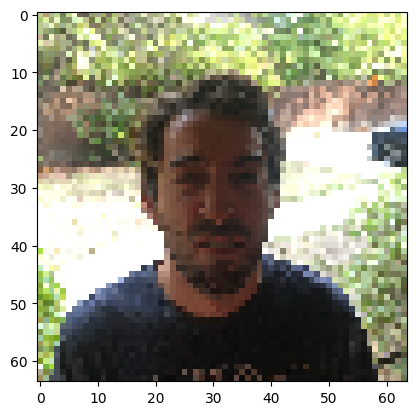

In [10]:
#your own image "my_image.jpg". 
img_path = 'images/my_image.jpg'

img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))